# Homework 6

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Tobias Rodriguez
* tobiasdelpozo@uchicago.edu

In [13]:
from functools import partial
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.style.use('ggplot')

import sys
if '../cmds/' not in sys.path:
    sys.path.append('../cmds/')
from portfolio_management_helper import *

import warnings
warnings.filterwarnings("ignore")

## 1 The Momentum Product
This section is not graded, and you do not need to submit your answers. But you are expected to consider these issues and be ready to discuss them.

Note: Same as last year (2023).

### 1.1 What is novel about the AQR Momentum product under construction compared to the various momentum investment products already offered?

- The AQR's Momentum product is a mutual fund, and thus any retail investors can invest.
- Two characterisitcs of mutual fund:
  1. Long-only: legally limited in their use of short positions and leverage
  2. Open-end: had to be ready to return capital at the end of the trading day to respond to investor redemptions

### 1.2 Name three reasons the momentum investment product will not exactly track the momentum index, (ie. why the strategy will have tracking error.)

1. AQR's fund would be long-only, whereas the index (Fama-french UMD) is long-short.
2. The index assumes monthly rebalancing, which may cause huge transaction cost. 
3. Fama-French UMD used all listed stocks, whereas AQR's fund would only use stocks with reasonable market capitalization and liquidity. This is because of "open-end" mutual fund regulation.

### 1.3 When constructing the momentum portfolio, AQR ranks stocks on their returns from month $t-12$ through $t-2$. Why don't they include the $t-1$ return in this ranking?

- The winning/losing stocks between $t − 1$ to $t$ may show short-term reversal, such that the momentum strategy would be hurt by including $t − 1$ return in the ranking.

## 2. Investigating Momentum

In this section, we empirically investigate some concerns regarding AQR's new momentum product.
On Canvas, find the data file, "**momentum_data.xlsx**".
- The first tab contains the momentum factor as an excess return: $\tilde{r}^{\mathrm{mom}}$.
- The second tab contains returns on portfolios corresponding to scored momentum deciles.
  - $r^{\operatorname{mom}(1)}$ denotes the portfolio of stocks in the lowest momentum decile, the "losers" with the lowest past returns.
  - $r^{\operatorname{mom}(10)}$ denotes the portfolio of stocks in the highest momentum decile.
- The third tab gives portfolios sorted by momentum and size.
  - $r^{\text {momsu }}$ denotes the portfolio of small stocks in the top 3 deciles of momentum scores.
  - $r^{\text {momBD }}$ denotes the portfolio of big-stocks in the bottom 3 deciles of momentum scores.

Note that the Fama-French momentum return, $\tilde{r}^{\mathrm{mom}: \mathrm{FF}}$, given in the first tab, is constructed by $\mathrm{FF}$ as,

$$
\tilde{r}^{\mathrm{mom}: \mathrm{FF}}=\frac{1}{2}\left(r^{\mathrm{momBU}}+r^{\mathrm{momSU}}\right)-\frac{1}{2}\left(r^{\mathrm{momBD}}+r^{\mathrm{momSD}}\right)
$$

In [14]:
raw_data = pd.read_excel('../data/momentum_data.xlsx',sheet_name = None)
sheets = list(raw_data.keys())

ff_factors = raw_data[sheets[1]].set_index('Date')
momentum = raw_data[sheets[2]].set_index('Date')
mom_deciles = raw_data[sheets[3]].set_index('Date')
tercile_port = raw_data[sheets[4]].set_index('Date')
rf = raw_data[sheets[5]].set_index('Date')

ff_factors['UMD'] = momentum['UMD']

The Fama-French momentum return

$$\tilde{r}^{mom:FF} = \frac{1}{2} (\tilde{r}^{momBU} + \tilde{r}^{momSU}) − \frac{1}{2} (\tilde{r}^{momBD} + \tilde{r}^{momSD}) $$

### 2.1 Is Momentum sill profitable?

The excess returns of lucrative trading strategies often disappear once the strategy is well-known. The first widely-cited paper on momentum was published in 1993. Have momentum returns or risk changed since then? The AQR case takes place at the end of 2008. Have momentum returns changed in 2009-2024?

Investigate by filling out the summary statistics below for the full-sample and three sub-samples.

#### (a) Using the data provided, fill in Table 1 with the appropriate stats for $\tilde{r}^{\text {mom:FF }}$.

$$
\begin{equation*}
\begin{aligned}
&\text { Table 2: Long-only momentum performance. }\\
&\begin{array}{llllll}
\hline \hline \text { Subsample } \quad \text { mean } \quad \text { vol } & \text { Sharpe } & \text { skewness } & \text { corr. to } \tilde{r}^m & \text { corr. to } \tilde{r}^v \\
\hline \hline & & & & \\
1927-2024 & & & \\
1927-1993 & & & \\
1993-2008 & & & \\
2009-2024 & & & \\
\hline \hline
\end{array}
\end{aligned}
\end{equation*}
$$

In [15]:
periods = [['1927', '2024'], ['1927', '1993'], ['1994', '2008'], ['2009', '2024']]
summary_col_names = ['Annualized Mean','Annualized Vol','Annualized Sharpe','Skewness']
res = []
for period in periods:
    temp = momentum.loc[period[0]:period[1]]
    temp_ff = ff_factors.loc[period[0]:period[1]]
    summary = calc_summary_statistics(temp, annual_factor=12, provided_excess_returns=True)[summary_col_names]
    summary['mkt_corr'] = temp_ff.corr().loc['MKT',['UMD']]
    summary['val_corr'] = temp_ff.corr().loc['HML',['UMD']]
    summary = summary.T.iloc[:,0].rename(f'{period[0]} - {period[1]}')
    res.append(summary)
summary  = pd.concat(res, axis=1).T
summary

,Annualized Mean,Annualized Vol,Annualized Sharpe,Skewness,mkt_corr,val_corr
1927 - 2024,0.0753,0.1625,0.4635,-2.9905,-0.3443,-0.4064
1927 - 1993,0.0901,0.1600,0.5630,-3.8082,-0.3625,-0.4950
1994 - 2008,0.1044,0.1756,0.5945,-0.5820,-0.2345,-0.1294
2009 - 2024,-0.0151,0.1585,-0.0952,-2.6910,-0.3676,-0.3209


#### (b) Has momentum changed much over time, as seen through these subsample statistics?

It doesn't change much in the most of the periods. But the momentum is showing negative return after 2009. It is reasonable stable between 1927 and 2008, and has been slightly negative since 2009. 

#### (c) Does this data support AQR's argument that momentum is an important piece of the ideal portfolio? What if mean returns to momentum are in actuality near zero due to transaction costs - would there still be evidence here that momentum is valuable?

Yes, It was definitely profitable at 2008 when AQR was considering to launch the momentum product. Also, the momentum has a low correlation with market and value factor, which makes it a good diversifier. Even if the mean return is near zero, the momentum is still valuable because of its low correlation with other factors. Notably, even though the return profile has changed, it has maintained lower correlations to the market and value factors. 

### 2.2. Whether a long-only implementation of momentum is valuable.

Construct your own long-only implementation:

$$\tilde{r}^{momU:FF} = \frac{1}{2} (\tilde{r}^{momBU} + \tilde{r}^{momSU}) − r^f $$

Note that this is following the FF approach of treating big and small stocks separately. This would be very similar to a scaled version of,

$$\tilde{r}^{momU} = \frac{1}{3} (\tilde{r}^{mom(8)} + \tilde{r}^{mom(9)} + \tilde{r}^{mom(10)}) − r^f $$


For the question below, use the FF-style $\tilde{r}^{momU:FF}_t$


#### (a) Fill out Table 2 for the data in the period 1994-2024.

$$
\begin{equation*}
\begin{aligned}
&\text { Table 2: Long-only momentum performance. }\\
&\begin{array}{llllll}
\hline \hline \text { 1994-2024 } & \text { mean } \quad \text { vol } & \text { Sharpe } & \text { skew } & \text { corr. to } \tilde{r}^m & \text { corr. to } \tilde{r}^v \\
\hline \hline \text { Long-and-short, }\left(\tilde{r}^{\text {mom:FF }}\right) & & & \\
\text { Long-only }\left(\tilde{r}^{\text {momU:FF }}\right) & & & \\
\hline \hline
\end{array}
\end{aligned}
\end{equation*}
$$

In [16]:
mom_long = (tercile_port['BIG HiPRIOR'] + tercile_port['SMALL HiPRIOR'])/2 - rf['RF']
mom_names = ['long_and_short','long_only']

temp = ff_factors.copy().rename(columns={'UMD':'long_and_short'})
temp['long_only']  = mom_long
summary =calc_summary_statistics(temp.loc["1994":, mom_names], annual_factor=12, provided_excess_returns=True)[summary_col_names]
summary['mkt_corr'] = temp.corr().loc['MKT', mom_names]
summary['val_corr'] = temp.corr().loc['HML', mom_names]
summary

,Annualized Mean,Annualized Vol,Annualized Sharpe,Skewness,mkt_corr,val_corr
long_and_short,0.0432,0.1677,0.2575,-1.4460,-0.3443,-0.4064
long_only,0.1172,0.1784,0.6569,-0.4448,0.9358,0.2105


#### (b)  Is long-only momentum as attractive as long-short momentum with respect to mean, volatil-ity, and Sharpe Ratio?

Yes, long-only looks even more attractive than long-short momentum. The mean return is higher, while the volatility is similar. Sharpe ratio is higher as well.

#### (c) Is long-only momentum as diversifying as long-short momentum with respect to market and value premia?


No, the long-only momentum portfolio has 93.6% of correlation with market, whereas the long-short momentum portfolio has -34% of correlation with market. This is because the long-only momentum portfolio is still exposed to market risk. Therefore, it does not diversify at all.

#### (d) Show a plot of the cumulative product of $1+\tilde{r}^{\text {mom:FF }}$ and $1+\tilde{r}^{\text {momU:FF }}$ over the 1994-2024 subsample. $^2$

Text(0.5, 1.0, 'Cumulative Returns')

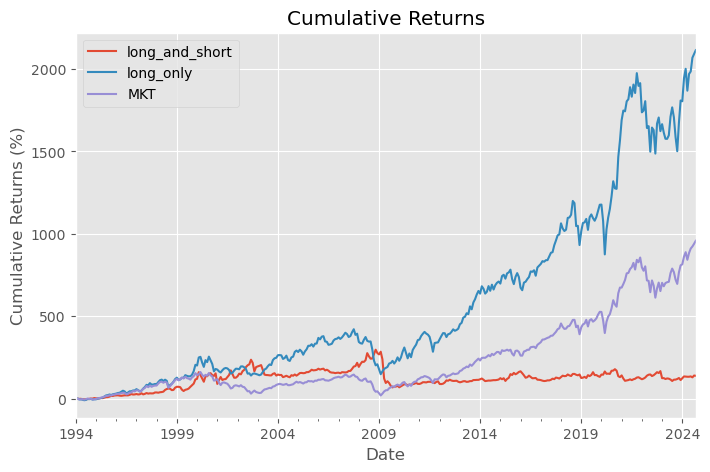

In [17]:
fig, ax = plt.subplots(figsize=(8,5))
(100 * ((1 + temp[mom_names + ['MKT']].loc['1994':]).cumprod() -1 )).plot(ax=ax)
ax.set_ylabel('Cumulative Returns (%)')
ax.set_title('Cumulative Returns')

### 2.3. Is momentum just data mining, or is it a robust strategy?

Assess how sensitive the threshold for the “winners” and “losers” is in the results. Specifically, we compare three constructions:

- long the top 1 decile and short the bottom 1 deciles:

$$ \tilde{r}^{momD1} = r^{mom(10)} - r^{mom(1)}$$

- long the top 3 deciles and short the bottom 3 deciles:


$$ 
\begin{aligned}
\tilde{r}^{momD3} &= \frac{1}{3}(r^{mom(8)} + r^{mom(9)} + r^{mom(10)}) - \frac{1}{3} (r^{mom(3)} + r^{mom(2)} + r^{mom(1)})\\
&= \frac{1}{3}\sum_{k = 8}^{10} r^{mom(k)} - \frac{1}{3}\sum_{k = 1}^{3} r^{mom(k)} 
\end{aligned}$$


- long the top 5 deciles and short the bottom 5 decile:

$$ \tilde{r}^{momD5} = \frac{1}{5}\sum_{k = 6}^{10} r^{mom(k)} - \frac{1}{5}\sum_{k = 1}^{5} r^{mom(k)} $$

#### (a) Compare all three constructions, (in the full-sample period,) by filling out the stats in the table below for the period 1994-2023.

$$
\begin{equation}
\begin{aligned}
&\text { Table 3: Robustness of momentum construction. }\\
&\begin{array}{lllllll}
\hline \hline \text { 1994-2024 } \quad \text { mean } & \text { vol } & \text { Sharpe } & \text { skewness } & \text { corr. to } \tilde{r}^m & \text { corr. to } \tilde{r}^v \\
\hline \hline \tilde{r}^{\text {momD1 }} & & & & & \\
\tilde{r}^{\text {momD3 }} & & & & \\
\tilde{r}^{\text {momD5 }} & & & & \\
\hline \hline
\end{array}
\end{aligned}
\end{equation}
$$

In [18]:
ls_1decile = mom_deciles['Hi PRIOR'] - mom_deciles['Lo PRIOR']
ls_3decile = mom_deciles.iloc[:,-3:].mean(axis = 1) - mom_deciles.iloc[:,:3].mean(axis = 1)
ls_5decile = mom_deciles.iloc[:,-5:].mean(axis = 1) - mom_deciles.iloc[:,:5].mean(axis = 1)

ls_names = ['mom_D1','mom_D3','mom_D5']
temp = ff_factors.copy()
temp[ls_names] = pd.concat([ls_1decile, ls_3decile, ls_5decile], axis=1)
summary = calc_summary_statistics(temp.loc["1994":, ls_names + ['UMD']], annual_factor=12, provided_excess_returns=True)[summary_col_names]
summary['mkt_corr'] = temp.corr().loc['MKT', ls_names + ['UMD']]
summary['val_corr'] = temp.corr().loc['HML', ls_names + ['UMD']]
summary

,Annualized Mean,Annualized Vol,Annualized Sharpe,Skewness,mkt_corr,val_corr
mom_D1,0.0820,0.2990,0.2742,-1.3046,-0.3690,-0.4044
mom_D3,0.0286,0.1934,0.1476,-1.3450,-0.3819,-0.3966
mom_D5,0.0164,0.1340,0.1225,-1.4159,-0.3617,-0.3918
UMD,0.0432,0.1677,0.2575,-1.4460,-0.3443,-0.4064


#### (b) Do the tradeoffs between the 1-decile, 3-decile, and 5-decile constructions line up with the theoretical tradeoffs we discussed in the lecture?

Yes, we can see long-short portfolio with higher threshold of decile has higher return, but also higher volatility.

#### (c) Should AQR's retail product consider using a 1-decile or 5-decile construction?

I would recommend 1-decile, as it has higher sharpe, but can also see the argument for a 5 decile construction due to likely lower turnover (and therefore lower fees for investors).

#### (d) Does $\tilde{r}^{\text {momD3 }}$ have similar stats to the Fama-French construction in (1). Recall that construction is also a 3-decile, long-short construction, but it is segmented for small and large stocks. Compare the middle row of Table 3 with the top row of Table 2.

They are similar, but Fama-French construction has higher return and lower volatility, resulting with higher sharpe ratio. Fama-French construction allows balance between small and large stocks, whereas top 3 deciles construction could be biased towards either small or large stocks.

### 2.4. Does implementing momentum require trading lots of small stocks-- thus causing even larger trading costs?

For regulatory and liquidity reasons, AQR is particularly interested in using larger stocks for their momentum baskets. (Though they will launch one product that focuses on medium-sized stocks.)

Use the data provided on both small-stock “winners”, $r^{momSU}$, and small-stock “losers”, $r^{momSD}$, to construct a small-stock momentum portfolio,

$$ r^{momS}_t = r^{momSU}_t - r^{momSD}_t $$

Similarly, use the data provided to construct a big-stock momentum portfolio,

$$ r^{momB}_t = r^{momBU}_t − r^{momBD}_t $$

#### (a) Fill out Table 4 over the sample 1994-2024.

$$
\begin{equation*}
\begin{aligned}
&\text { Table 4: Momentum of small and big stocks. }\\
&\begin{array}{llllll}
\hline \hline \text { 1994-2024 } & \text { mean } & \text { vol } & \text { Sharpe } & \text { skewness } & \text { corr. to } \tilde{r}[m] \\
\hline \hline \text { All stocks, } \tilde{r}^{\text {mom:FF }} & & & & \\
\text { Small stocks } r_t^{\text {mom } S} & & & \\
\text { Large stocks } r_t^{\text {mom } B} & & & \\
\hline
\end{array}
\end{aligned}
\end{equation*}
$$

In [19]:
mom_small = tercile_port['SMALL HiPRIOR'] - tercile_port['SMALL LoPRIOR']
mom_large = tercile_port['BIG HiPRIOR'] - tercile_port['BIG LoPRIOR']

mom_size_name = ['Small_stocks','Big_stocks']
temp = ff_factors.copy()
temp[mom_size_name] = pd.concat([mom_small, mom_large], axis=1)
summary = calc_summary_statistics(temp.loc["1994":, ['UMD'] + mom_size_name], annual_factor=12, provided_excess_returns=True)[summary_col_names]
summary['mkt_corr'] = temp.corr().loc['MKT', ['UMD'] + mom_size_name]
summary['val_corr'] = temp.corr().loc['HML', ['UMD'] + mom_size_name]
summary.rename({'UMD':'All_stocks'})

,Annualized Mean,Annualized Vol,Annualized Sharpe,Skewness,mkt_corr,val_corr
All_stocks,0.0432,0.1677,0.2575,-1.4460,-0.3443,-0.4064
Small_stocks,0.0632,0.1696,0.3726,-1.7636,-0.3315,-0.3882
Big_stocks,0.0232,0.1825,0.1270,-0.8791,-0.3249,-0.3863


#### (b) Is the attractiveness of the momentum strategy mostly driven by the small stocks? That is, does a momentum strategy in large stocks still deliver excess returns at comparable risk?

Yes, the small stock momentum portfolio has almost 3 time higher sharpe ratio than the large stock momentum portfolio. Still, the large stock momentum portfolio delivers positive excess return.

### 2.5. In conclusion, what is your assessment of the AQR retail product? Is it capturing the important features of the Fama-French construction of momentum? Would you suggest any modifications?

- AQR's retail product uses a long only approach which leads to a higher correlation with the Market and has less diversification benefits compared to the benchmark index or Fama-French momentum factor.
- Quarterly rebalancing might make the portfolio diverge from the benchmark index and Fama-French momentum factor.

## 3 Barnstable's Analysis

*This section is not graded, and you do not need to submit your answers.*
**We may discuss these problems later, but they will not be covered in Midterm 2.**

### 3.1 Barnstable's Philosophy
a. What has Barnstable's investment strategy been in the past?

They believed that in the long-run, stocks would outperform bonds and treasuries. They has a 40% allocation to the S&P 500, 30% to actively managed US stocks, and 30% to actively managed international stocks.

b. Explain the logic behind their view that stocks are safer in the long run.

Law of large numbers (time diversification): if each day is like a coin-flip with a positive expected value, then the more days you have, the more likely you are to make money. Aditionally, because of being "serially" uncorrelated, the movements cancel out. And your sharpe ratio increases with time.

c. What assumptions underly Barnstable's belief in the long-run safety of stocks?

Independence of returns, and that the expected return is positive.

### 3.2 Two Proposals

a. Describe the two proposals Barnstable is considering for how to take advantage of their view regarding the long-run safety of stocks.

1. Selling puts on the S&P 500 index, which were at a premium (due to vol skew).
2. Selling shares on a pool of S&P 500 stocks, where (1) class of shares would return the minimum of the S&P return and 6%, and (2) would return whatever was left over from (1). They can then sell (1) and keep (2).

What is (1) the same as? Selling a covered call option on the S&P 500 index.

c. Do these proposals take the same bet on long-run stock performance? In what outcomes would they differ?

I would say yes, since both want the S&P 500 to go up. However, they are different if:

1. If the S&P 500 goes up, then (1) is strictly better than (2). The reason being that (2) is always capped at return - 6%, whereas (1) is not capped, and is in-fact boosted by the premium from the put.
2. If S&P 500 goes down, the (1) is worse than (2), since you're also short puts in addition to being long the S&P 500.

d. Do the two proposals differ in their risk?

I would say (1) is probably riskier than (2), due to amplified downside risk.

3. Do you recommend a direct investment in the S&P, the trust, or the puts?

If Barnstable truly believes that the S&P will go up, and the probability of selling puts is that low, then yes, selling the puts doubles-down on their investment philosophy. However, just buying the S&P 500 is less risky and you are getting *that* much premium from selling the puts, so it is the best option.

The trust is some concoction dreamed up by a banker to collect fees, and is a terrible idea.

For readers of Money Stuff, the second proposal is something like:

![image](etf_cap.png)

## 4 Estimating Underperformance

In [20]:
data = pd.read_excel('../data/barnstable_analysis_data.xlsx', sheet_name=1).set_index('date').fillna(method = 'ffill')
data['excess_returns'] = data['SPX'] - data['TB1M'] 
rets = data['excess_returns']

In [21]:
agg_years = [(1965, 1999), (2000, 2023), (1926, 2023)]
def calc_analytics_by_year(data, agg_years):
    res = []
    for y in agg_years:
        sub = data.loc[str(y[0]):str(y[1])]
        res.append({'mean': sub.mean() * 12, 'vol': sub.std() * np.sqrt(12)})
    return pd.DataFrame(res, index = [f'{i[0]} - {i[1]}' for i in agg_years]).stack()

sum_stats = data.apply(calc_analytics_by_year, agg_years = agg_years).T
log_sum_stats = np.log(1 + data).apply(calc_analytics_by_year, agg_years = agg_years).T

res_stats = pd.concat([sum_stats, log_sum_stats])
res_stats.index = pd.MultiIndex.from_product([['levels','logs'], sum_stats.index.to_list()])
res_stats.style.format('{:,.2%}')

### 4.2

SPX underperforming RF in the next 15 years after 1999: 7.42%
SPX underperforming RF in the next 30 years after 1999: 2.05%


<Axes: >

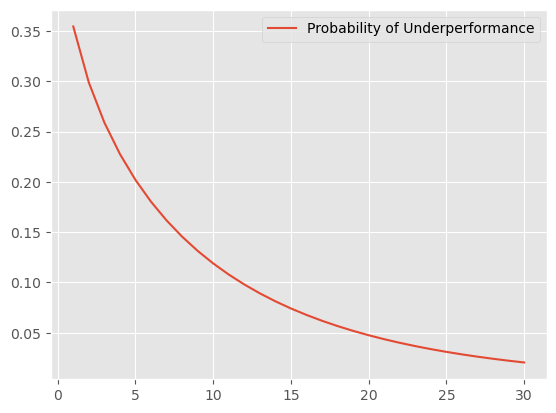

In [22]:
from scipy.stats import norm
def prob(mu, sigma, h):
    return norm.cdf(np.sqrt(h)*mu/sigma)

mu, sigma = res_stats['1965 - 1999'].loc[('logs', 'excess_returns')]

print(f'SPX underperforming RF in the next 15 years after 1999: {prob(mu = -mu, sigma = sigma, h = 15):,.2%}')

print(f'SPX underperforming RF in the next 30 years after 1999: {prob(mu = -mu, sigma = sigma, h = 30):,.2%}')

h = np.arange(30) + 1
probs = pd.DataFrame([prob(-mu, sigma, x) for x in h], columns=['Probability of Underperformance'], index = h)
probs.plot()

### 4.3

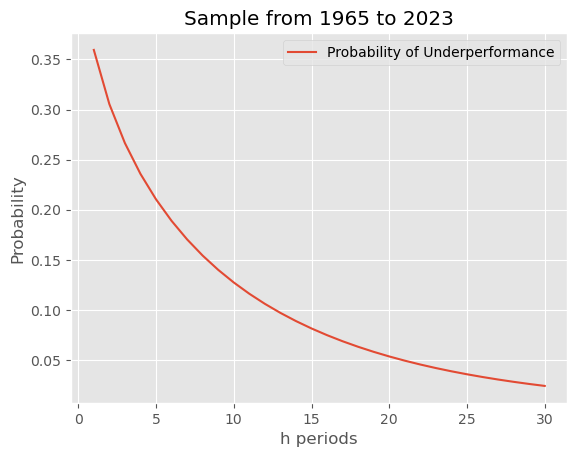

In [23]:
mu = np.log(1+rets.loc['1965':'2023']).mean() * 12
sigma = np.log(1+rets.loc['1965':'2023']).std() * np.sqrt(12)
h = np.arange(30)+1

probs = pd.DataFrame([1 - prob(mu, sigma, x) for x in h], columns=['Probability of Underperformance'], index = h)
probs.plot(title = 'Sample from 1965 to 2023', ylabel = 'Probability', xlabel = 'h periods')
plt.show()

### 4.4

In [24]:
mu = res_stats[('1965 - 1999', 'mean')].loc[('logs', 'SPX')] - res_stats[('2000 - 2023', 'mean')].loc[('logs', 'SPX')]
sigma = res_stats[('1965 - 1999', 'vol')].loc[('logs', 'SPX')]

print(f"Probability of underperformance in 2000-2023: {prob(-mu, sigma, 24):,.2%}")

Probability of underperformance in 2000-2023: 5.64%
